# Random Forest

In [1]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

First, we load the data:

In [2]:
# Dataframe
path_df = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

Let's check the dimension of our feature vectors:

In [17]:
print(features_train.shape)
print(features_test.shape)
print(df['label'][:5])
print(features_train[:5])

(2676, 300)
(473, 300)
0                      criticism
1    notification of information
2                       donation
3                      criticism
4                           hoax
Name: label, dtype: object
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.56052777 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


## Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [4]:
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

* `n_estimators` = number of trees in the forest.
* `max_features` = max number of features considered for splitting a node
* `max_depth` = max number of levels in each decision tree
* `min_samples_split` = min number of data points placed in a node before the node is split
* `min_samples_leaf` = min number of data points allowed in a leaf node
* `bootstrap` = method for sampling data points (with or without replacement)

### Randomized Search Cross Validation

We first need to define the grid:

In [5]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


Then, we'll perform the Random Search:

In [ ]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=4, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


We can see the best hyperparameters resulting from the Random Search:

In [ ]:
print(random_search.best_params_)
print(random_search.best_score_)

After that, we can do a more exhaustive search centered in those values:

### Grid Search Cross Validation

In [6]:
# Create the parameter grid based on the results of random search 
bootstrap = [True]
max_depth = [70, 80, 90]
max_features = ['auto']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=RandomForestClassifier(random_state=8),
             param_grid={'bootstrap': [True], 'max_depth': [70, 80, 90],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [800]},
             scoring='accuracy', verbose=1)

The best hyperparameters turn out to be:

In [7]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'bootstrap': True, 'max_depth': 70, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 800}
0.926470588235294


Let's save the model in `best_rfc`:

In [8]:
best_rfc =  grid_search.best_estimator_

We now know the best random forest model. Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [9]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(max_depth=70, min_samples_split=15, n_estimators=800,
                       random_state=8)

And get the predictions:

In [10]:
rfc_pred = best_rfc.predict(features_test)

The conditional class probabilities can be obtained by typing:

`rfc_pred = best_rfc.predict_proba(features_test)`

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

#### Training accuracy

In [11]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
0.9786995515695067


#### Test accuracy

In [12]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.945031712473573


#### Classification report

In [13]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       0.98      0.95      0.96        86
           2       0.82      0.88      0.85        73
           3       0.89      0.85      0.87        88

    accuracy                           0.95       473
   macro avg       0.92      0.92      0.92       473
weighted avg       0.95      0.95      0.95       473



#### Confusion matrix

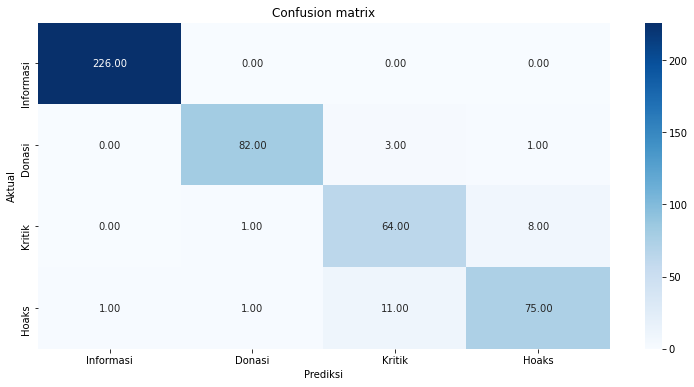

In [21]:
aux_df = df[['label', 'label_code']].drop_duplicates().sort_values('label_code')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
aux_df['label'].values[0]='Informasi'
aux_df['label'].values[1]='Donasi'
aux_df['label'].values[2]='Kritik'
aux_df['label'].values[3]='Hoaks'
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['label'].values, 
            yticklabels=aux_df['label'].values,
            cmap="Blues", fmt='.2f')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

```python
features_time = features_train
elapsed_list = []
for i in range(0,10):
    
    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
```

Let's see if the hyperparameter tuning process has returned a better model:

In [22]:
base_model = RandomForestClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9429175475687104

In [23]:
best_rfc.fit(features_train, labels_train)
accuracy_score(labels_test, best_rfc.predict(features_test))

0.945031712473573

We'll create a dataset with a model summary to compare models:

In [24]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

df_models_rfc = pd.DataFrame(d, index=[0])

In [25]:
df_models_rfc

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,0.9787,0.945032


Let's save the model and this dataset:

In [26]:
with open('Models/best_rfc.pickle', 'wb') as output:
    pickle.dump(best_rfc, output)
    
with open('Models/df_models_rfc.pickle', 'wb') as output:
    pickle.dump(df_models_rfc, output)
    


In [154]:
# Dataframe
path_df = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/03. Feature Engineering/Pickles_title/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)
    
# X_train
path_X_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/03. Feature Engineering/Pickles_title/X_train.pickle"
with open(path_X_train, 'rb') as data:
    X_train = pickle.load(data)

# X_test
path_X_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/03. Feature Engineering/Pickles_title/X_test.pickle"
with open(path_X_test, 'rb') as data:
    X_test = pickle.load(data)

# y_train
path_y_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/03. Feature Engineering/Pickles_title/y_train.pickle"
with open(path_y_train, 'rb') as data:
    y_train = pickle.load(data)

# y_test
path_y_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/03. Feature Engineering/Pickles_title/y_test.pickle"
with open(path_y_test, 'rb') as data:
    y_test = pickle.load(data)

# features_train
path_features_train = "C:/Users/asus-pc/Documents/PBA/Untitled Folder/Tugas Akhir/03. Feature Engineering/Pickles_title/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "C:/Users/asus-pc/Documents/PBA/Untitled Folder/Tugas Akhir/03. Feature Engineering/Pickles_title/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)
    
# SVM Model
path_model = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/04. Model Training/Models/best_RFC.pickle"
with open(path_model, 'rb') as data:
    svc_model = pickle.load(data)
    
# Category mapping dictionary
category_codes = {
    'notification of information': 0,
    'donation': 1,
    'criticism': 2,
    'hoax': 3,
}

category_names = {
    0: 'notification of information',
    1: 'donation',
    2: 'criticism',
    3: 'hoax'
}

In [155]:
predictions = svc_model.predict(features_test)

In [156]:
# Indexes of the test set
index_X_test = X_test.index

# We get them from the original df
df_test = df.loc[index_X_test]

# Add the predictions
df_test['prediction'] = predictions

# Clean columns
df_test = df_test[['title', 'label', 'label_code', 'prediction']]

# Decode
df_test['label_predicted'] = df_test['prediction']
df_test = df_test.replace({'label_predicted':category_names})

# Clean columns again
df_test = df_test[['title', 'label', 'label_predicted']]

In [157]:
df_test.head()

,title,label,label_predicted
2182,Update Corona Indonesia 24 Oktober 2020 dan Se...,notification of information,notification of information
1279,Pertamina Diminta Lihat Fluktuasi Harga Minyak...,criticism,criticism
1729,UPDATE 17 Januari: Ada 145.482 Kasus Aktif Cov...,notification of information,notification of information
1477,"Sebaran 4.002 Kasus Positif Hari Ini, DKI-Jaba...",donation,donation
1964,UPDATE Corona 31 Maret di 32 Provinsi: Kasus B...,notification of information,notification of information


In [158]:
condition = (df_test['label'] != df_test['label_predicted'])

df_misclassified = df_test[condition]
df_misclassified.head(5)

,title,label,label_predicted
1454,Satgas Covid-19 dan Polda Jabar Diminta Panggi...,criticism,hoax
360,Buntut Kasus Kerumunan Massa Rizieq Shihab: Gi...,criticism,hoax
2772,UPDATE Lengkap 5 Fakta Warga Depok Positif Vir...,hoax,notification of information
945,Kominfo Catat Ada 2 Ribu Lebih Konten Hoax Ten...,hoax,criticism
1324,Polri Tidak Berikan Izin Keramaian Pelaksanaan...,donation,criticism


In [159]:
len(df_misclassified)

32

In [160]:
def output_article(row_article):
    print('Actual Category: %s' %(row_article['label']))
    print('Predicted Category: %s' %(row_article['label_predicted']))
    print('-------------------------------------------')
    print('Text: ')
    print('%s' %(row_article['title']))

In [161]:
random.seed()
list_samples = random.sample(list(df_misclassified.index), 3)
list_samples

[360, 3019, 1119]

In [162]:
output_article(df_misclassified.loc[list_samples[0]])

Actual Category: criticism
Predicted Category: hoax
-------------------------------------------
Text: 
Buntut Kasus Kerumunan Massa Rizieq Shihab: Gibran Disinggung, Pejabat Dipanggil, Kapolda Dicopot


In [163]:
output_article(df_misclassified.loc[list_samples[1]])

Actual Category: donation
Predicted Category: criticism
-------------------------------------------
Text: 
Vaksin Covid-19 Batch 1 Kedaluwarsa 25 Maret, Bio Farma Pastikan Sudah Diberikan Kepada Nakes


In [164]:
output_article(df_misclassified.loc[list_samples[2]])

Actual Category: donation
Predicted Category: criticism
-------------------------------------------
Text: 
Narapidana Sumbangkan Hasil Karyanya untuk Penanganan Corona di Indonesia
